# Wine Quality Prediction: Tabular Foundation Models vs. Tree-Based Methods

In [4]:
import os
from dotenv import load_dotenv

load_dotenv()
hf_token = os.getenv("HFTOKEN")

Shape: (4898, 12)
Columns: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']

Dtypes:
 fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

Missing values per column:
 fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

Head:
    fixed acidity  vo

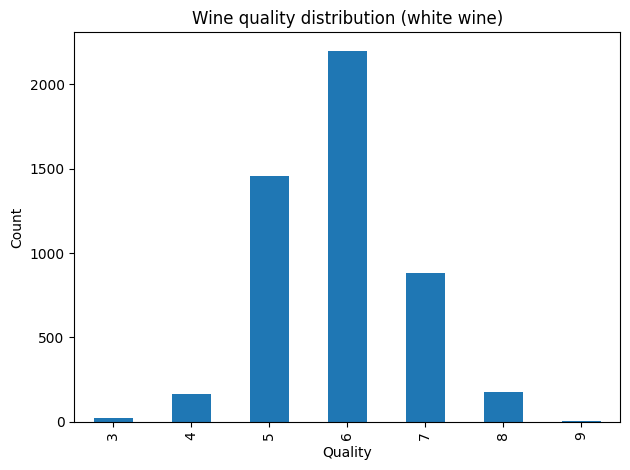

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tabpfn import TabPFNClassifier
from tabicl import TabICLClassifier

path = "./data/winequality-white.csv"
df = pd.read_csv(path, sep=";")

print("Shape:", df.shape)
print("Columns:", list(df.columns))
print("\nDtypes:\n", df.dtypes)
print("\nMissing values per column:\n", df.isna().sum())

pd.set_option("display.width", 140)
pd.set_option("display.max_columns", 50)

print("\nHead:\n", df.head())
print("\nSummary stats:\n", df.describe(include="all").T)

target_col = "quality"
quality_counts = df[target_col].value_counts().sort_index()
print("\nQuality value counts:\n", quality_counts)

plt.figure()
quality_counts.plot(kind="bar")
plt.xlabel("Quality")
plt.ylabel("Count")
plt.title("Wine quality distribution (white wine)")
plt.tight_layout()
plt.show()